# Деревья решений решают проблемы
__Суммарное количество баллов: 10__

Вы уже знакомы с классификацией методом KNN. В этом задании предстоит реализовать другой метод классификации - дерево решений. 

Одной из его особенностей является возможность объяснить в человекочитаемой форме, почему мы отнесли объект к определенному классу. Эта особенность позволяет использовать деревья решений для создания систем, которые могут подсказывать специалистам, на что именно стоит обратить внимание при принятии решений.

In [1]:
import numpy as np
import pandas
import random
import matplotlib.pyplot as plt
import matplotlib

In [32]:
import pandas as pd
from collections import Counter

### Задание 1 (1 балл)
Во время построения дерева решений нам потребуется определить, какой из предикатов лучше всего разбивает обучающую выборку. Есть два критерия, которые позволяют это сделать: критерий Джини и энтропийный критерий. Первый для подсчета информативности разбиения использует коэффициент Джини, второй - энтропию. Реализуйте подсчет этих коэффициентов, а так же подсчет информативности разбиения. 

#### Описание функций
`gini(x)` считает коэффициент Джини для массива меток

`entropy(x)` считает энтропию для массива меток

`gain(left_y, right_y, criterion)` считает информативность разбиения массива меток на левую `left_y` и правую `right_y` части при помощи `criterion`, который задается функцией (не строкой).

In [74]:
def gini(x):
    l = len(x)
    C = Counter(x)
    P = np.array([C[k]/l for k in C])
    GG = 1 - sum(P ** 2)
    return GG
    
def entropy(x):
    l = len(x)
    C = Counter(x)
    P = np.array([C[k]/l for k in C])
    IG = -sum(P*np.log2(P))
    return IG

def gain(left_y, right_y, criterion):
    left_l = len(left_y)
    right_l = len(right_y)
    total_l = left_l + right_l
    res = criterion(np.concatenate((left_y, right_y))) - left_l / total_l * criterion(left_y) - right_l/total_l * criterion(right_y)
    return res

### Задание 2 (1 балл)
Деревья решений имеют хорошую интерпретируемость, т.к. позволяют не только предсказать класс, но и объяснить, почему мы предсказали именно его. Например, мы можем его нарисовать. Чтобы сделать это, нам необходимо знать, как оно устроено внутри. Реализуйте классы, которые будут задавать структуру дерева. 

#### DecisionTreeLeaf
Поля:
1. `y` должно содержать класс, который встречается чаще всего среди элементов листа дерева

#### DecisionTreeNode
В данной домашней работе мы ограничемся порядковыми и количественными признаками, поэтому достаточно хранить измерение и значение признака, по которому разбиваем обучающую выборку.

Поля:
1. `split_dim` измерение, по которому разбиваем выборку
2. `split_value` значение, по которому разбираем выборку
3. `left` поддерево, отвечающее за случай `x[split_dim] < split_value`. Может быть `DecisionTreeNode` или `DecisionTreeLeaf`
4. `right` поддерево, отвечающее за случай `x[split_dim] >= split_value`. Может быть `DecisionTreeNode` или `DecisionTreeLeaf`

__Интерфейс классов можно и нужно менять при необходимости__ (например, для вычисления вероятности в следующем задании)

In [181]:
class DecisionTreeLeaf:
    def __init__(self, y):
        self._C = Counter(y)
        self._l = len(y)
        self.y = self._C.most_common(1)[0][0]
        self.probs = {k: self._C[k]/self._l for k in self._C}

class DecisionTreeNode:
    def __init__(self, X, y, split_dim, split_value, level, left=None, right=None):
        self.split_dim = split_dim
        self.split_value = split_value
        self.left = left
        self.right = right
        self.level = level
        self.X = X
        self.y = y
    
    def __repr__(self):
        return f'DecisionTreeNode ({self.split_dim=}, {self.split_value=}, {self.level=})'


### Задание 3 (6 баллов)
Теперь перейдем к самому дереву решений. Реализуйте класс `DecisionTreeClassifier`.

#### Описание методов
`fit(X, y)` строит дерево решений по обучающей выборке.

`predict_proba(X)` для каждого элемента из `X` возвращает словарь `dict`, состоящий из пар `(класс, вероятность)`. Вероятности классов в листе можно определить через количество объектов соответствующего класса в листе. 

#### Описание параметров конструктора
`criterion="gini"` - задает критерий, который будет использоваться при построении дерева. Возможные значения: `"gini"`, `"entropy"`.

`max_depth=None` - ограничение глубины дерева. Если `None` - глубина не ограничена

`min_samples_leaf=1` - минимальное количество элементов в каждом листе дерева.

#### Описание полей
`root` - корень дерева. Может быть `DecisionTreeNode` или `DecisionTreeLeaf`

In [182]:
class DecisionTreeClassifier:
    def __init__(self, criterion="gini", max_depth=None, min_samples_leaf=1):
        self.root = None
        self.criterion = {'gini': gini, 'entropy': entropy}.get(criterion)
        self.max_depth = max_depth
        self.min_samples_leaf = min_samples_leaf
    
    def fit(self, X, y):
        if len(Counter(y)) == 1 or len(y) < self.min_samples_leaf or self.max_depth == 1:
            # Критерий для листа: 
            # у всех точек один класс или 
            # достигнут минимум точек для листа или 
            # максимум глубины
            self.root = DecisionTreeLeaf(y)
            return
        
        best_gain, best_thres, best_col = self._best_split(X, y)
        self.root = DecisionTreeNode(X, y, split_dim=best_col, split_value=best_thres, level=1)
        queue = [self.root]
        while queue:
            node = queue.pop()
            left = node.X[:, node.split_dim] < node.split_value
            right = np.logical_not(left)
            left_y = node.y[left]
            right_y = node.y[right]
            
            if len(Counter(left_y)) == 1 or len(left_y) < self.min_samples_leaf or node.level == self.max_depth:
                node.left = DecisionTreeLeaf(left_y)
            else:
                best_gain, best_thres, best_col = self._best_split(node.X[left, :], left_y)
                node.left = DecisionTreeNode(node.X[left, :], left_y, \
                                             split_dim=best_col, split_value=best_thres, level=node.level+1)
                queue.append(node.left)
            
            if len(Counter(right_y)) == 1 or len(right_y) < self.min_samples_leaf or node.level == self.max_depth:
                node.right = DecisionTreeLeaf(right_y)
            else:
                best_gain, best_thres, best_col = self._best_split(node.X[right, :], right_y)
                node.right = DecisionTreeNode(node.X[right, :], right_y, \
                                             split_dim=best_col, split_value=best_thres, level=node.level+1)
                queue.append(node.right)
            
        
    
    def predict_proba(self, X):
        rows, _ = X.shape
        res = []
        for i in range(rows):
            x = X[i, :]
            n = self.root
            while not isinstance(n, DecisionTreeLeaf):
                if x[n.split_dim] < n.split_value:
                    n = n.left
                else:
                    n = n.right
            res.append(n.probs)
        return res
        
    
    def predict(self, X):
        proba = self.predict_proba(X)
        return [max(p.keys(), key=lambda k: p[k]) for p in proba]
    
    def _best_split(self, X, y):
        _, cols = X.shape
        splits = []
        for col in range(cols):
            # Считаем gain по точкам между уникальными значениями по каждому столбцу
            values = np.unique(X[:, col])
            col_split_candidates = [ (values[i] + values[i+1])/2 for i in range(len(values)-1)]

            for split_candidate in col_split_candidates:
                left = X[:, col] < split_candidate
                right = np.logical_not(left)
                y_left = y[left]
                y_right = y[right]
                splits.append((gain(y_left, y_right, self.criterion), split_candidate, col))

        return max(splits)

Построенное дерево можно нарисовать. Метод `draw_tree` рисует дерево и сохраняет его в указанный файл.

In [109]:
def tree_depth(tree_root):
    if isinstance(tree_root, DecisionTreeNode):
        return max(tree_depth(tree_root.left), tree_depth(tree_root.right)) + 1
    else:
        return 1

def draw_tree_rec(tree_root, x_left, x_right, y):
    x_center = (x_right - x_left) / 2 + x_left
    if isinstance(tree_root, DecisionTreeNode):
        x_center = (x_right - x_left) / 2 + x_left
        x = draw_tree_rec(tree_root.left, x_left, x_center, y - 1)
        plt.plot((x_center, x), (y - 0.1, y - 0.9), c=(0, 0, 0))
        x = draw_tree_rec(tree_root.right, x_center, x_right, y - 1)
        plt.plot((x_center, x), (y - 0.1, y - 0.9), c=(0, 0, 0))
        plt.text(x_center, y, "x[%i] < %f" % (tree_root.split_dim, tree_root.split_value),
                horizontalalignment='center')
    else:
        plt.text(x_center, y, str(tree_root.y),
                horizontalalignment='center')
    return x_center

def draw_tree(tree, save_path=None):
    td = tree_depth(tree.root)
    plt.figure(figsize=(0.33 * 2 ** td, 2 * td))
    plt.xlim(-1, 1)
    plt.ylim(0.95, td + 0.05)
    plt.axis('off')
    draw_tree_rec(tree.root, -1, 1, td)
    plt.tight_layout()
    if save_path is not None:
        plt.savefig(save_path)
    plt.show()

Для двумерного набора данных дерево можно отобразить на плоскости с данными. Кроме того, как и для любого классификатора, для него можно построить roc-кривую

In [134]:
def plot_roc_curve(y_test, p_pred):
    positive_samples = sum(1 for y in y_test if y == 0)
    tpr = []
    fpr = []
    for w in np.arange(-0.01, 1.02, 0.01):
        y_pred = [(0 if p.get(0, 0) > w else 1) for p in p_pred]
        tpr.append(sum(1 for yp, yt in zip(y_pred, y_test) if yp == 0 and yt == 0) / positive_samples)
        fpr.append(sum(1 for yp, yt in zip(y_pred, y_test) if yp == 0 and yt != 0) / (len(y_test) - positive_samples))
    plt.figure(figsize = (7, 7))
    plt.plot(fpr, tpr)
    plt.plot([0, 1], [0, 1], linestyle="--")
    plt.xlabel("False positive rate")
    plt.ylabel("True positive rate")
    plt.xlim(-0.01, 1.01)
    plt.ylim(-0.01, 1.01)
    plt.tight_layout()
    plt.show()

def rectangle_bounds(bounds):
    return ((bounds[0][0], bounds[0][0], bounds[0][1], bounds[0][1]), 
            (bounds[1][0], bounds[1][1], bounds[1][1], bounds[1][0]))

def plot_2d_tree(tree_root, bounds, colors):
    if isinstance(tree_root, DecisionTreeNode):
        if tree_root.split_dim:
            plot_2d_tree(tree_root.left, [bounds[0], [bounds[1][0], tree_root.split_value]], colors)
            plot_2d_tree(tree_root.right, [bounds[0], [tree_root.split_value, bounds[1][1]]], colors)
            plt.plot(bounds[0], (tree_root.split_value, tree_root.split_value), c=(0, 0, 0))
        else:
            plot_2d_tree(tree_root.left, [[bounds[0][0], tree_root.split_value], bounds[1]], colors)
            plot_2d_tree(tree_root.right, [[tree_root.split_value, bounds[0][1]], bounds[1]], colors)
            plt.plot((tree_root.split_value, tree_root.split_value), bounds[1], c=(0, 0, 0))
    else:
        x, y = rectangle_bounds(bounds)
        plt.fill(x, y, c=colors[tree_root.y] + [0.2])

def plot_2d(tree, X, y):
    plt.figure(figsize=(9, 9))
    colors = dict((c, list(np.random.random(3))) for c in np.unique(y))
    bounds = list(zip(np.min(X, axis=0), np.max(X, axis=0)))
    plt.xlim(*bounds[0])
    plt.ylim(*bounds[1])
    plot_2d_tree(tree.root, list(zip(np.min(X, axis=0), np.max(X, axis=0))), colors)
    for c in np.unique(y):
        plt.scatter(X[y==c, 0], X[y==c, 1], c=[colors[c]], label=c)
    plt.legend()
    plt.tight_layout()
    plt.show()

## Задание 4 (2 балла)

Протестируйте решение на данных cancer и spam (датасеты из директории `hw2_data`).
Выполните загрузку и предобработку данных.


Если необходимо, попробуйте разные наборы параметров для получения лучшего результата.

Посчитайте метрики `precision`, `recall`, `accuracy` для модели дерева.
Сравните значения метрик с результатами модели kNN из предыдущего задания (можно использовать реализацию из библиотеки `sklearn`). 

Какой нужен препроцессинг данных для моделей?
Какая модель делает предсказания лучше?  Предположите, почему.

_Ваш ответ_

In [149]:
from sklearn.metrics import accuracy_score, recall_score, precision_score
from sklearn.neighbors import KNeighborsClassifier

In [136]:
from sklearn.model_selection import train_test_split

In [150]:
metrics = {'accuracy': accuracy_score, 
           'recall': recall_score, 
           'precision': precision_score}

**spam dataset**

In [159]:
spam = pd.read_csv('hw2_data/spam.csv')

In [160]:
y = spam['label'].to_numpy()
X = spam.drop(columns='label').to_numpy()

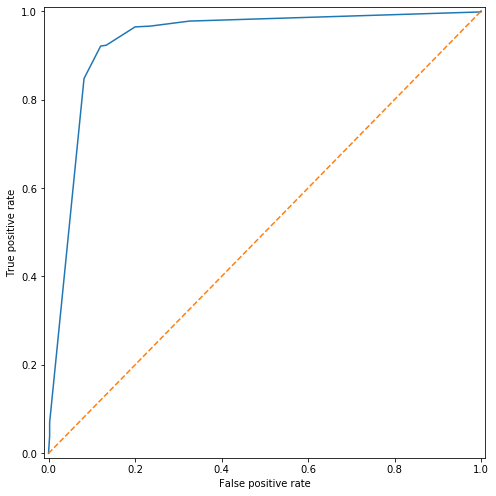

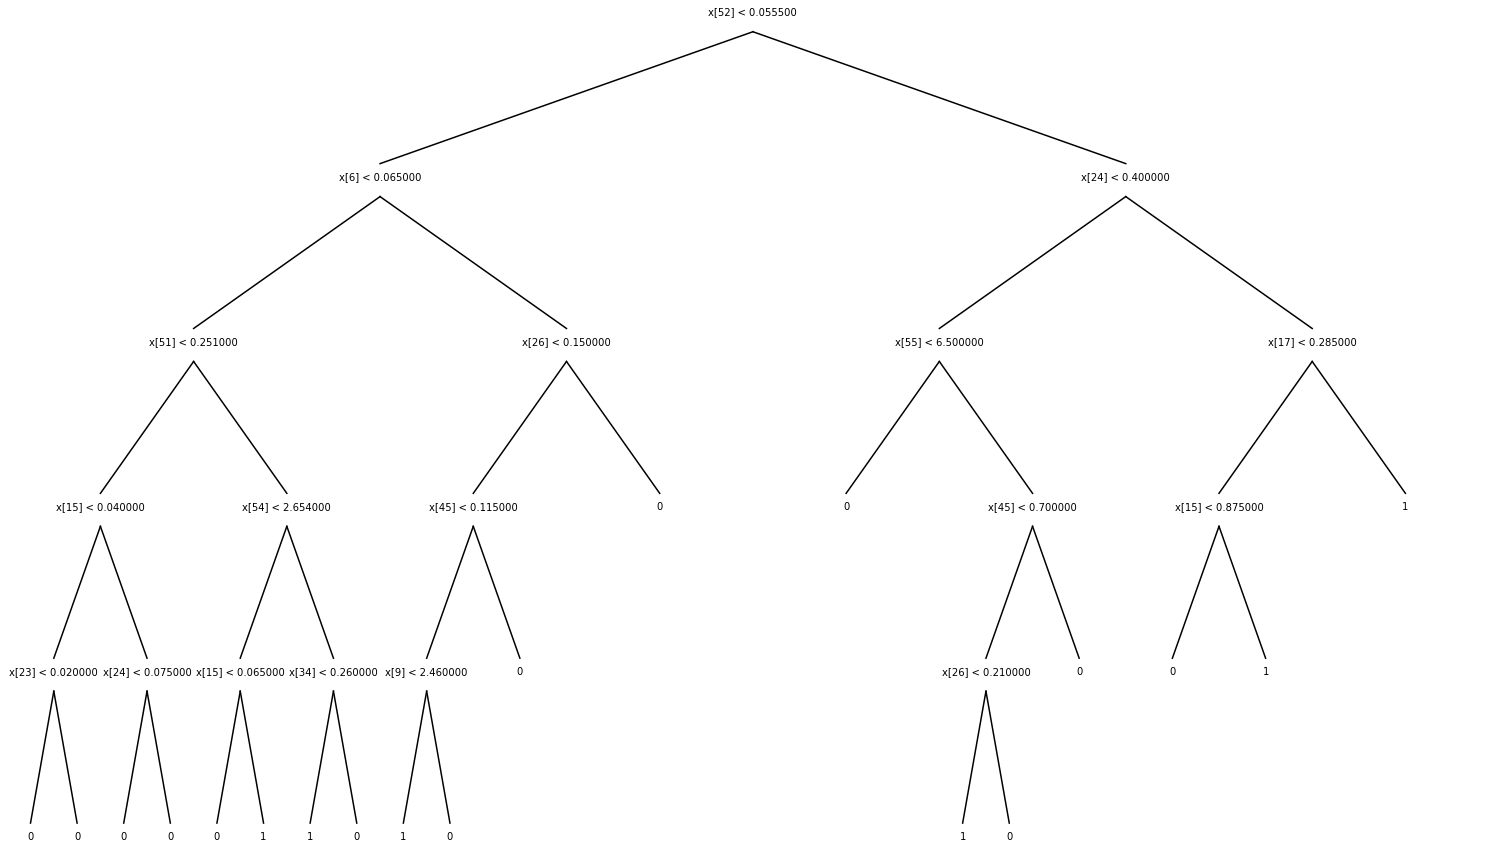

In [163]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
tree = DecisionTreeClassifier(max_depth=5, min_samples_leaf=30)
tree.fit(X_train, y_train)
plot_roc_curve(y_test, tree.predict_proba(X_test))
draw_tree(tree)

In [164]:
y_pred = tree.predict(X_test)

In [165]:
knn = KNeighborsClassifier()
knn.fit(X_train, y_train)
knn_pred = knn.predict(X_test)

In [166]:
print('Tree metrics:')
for label, metric in metrics.items():
    print(f'\t{label}: {metric(y_test, y_pred):.2f}')
print('KNN metrics:')
for label, metric in metrics.items():
    print(f'\t{label}: {metric(y_test, knn_pred):.2f}')  

Tree metrics:
	accuracy: 0.89
	recall: 0.80
	precision: 0.94
KNN metrics:
	accuracy: 0.79
	recall: 0.71
	precision: 0.77


**cancer dataset**

In [167]:
cancer = pd.read_csv('hw2_data/cancer.csv')
y = (cancer['label'].to_numpy() == 'M').astype(int)
X = cancer.drop(columns='label').to_numpy()

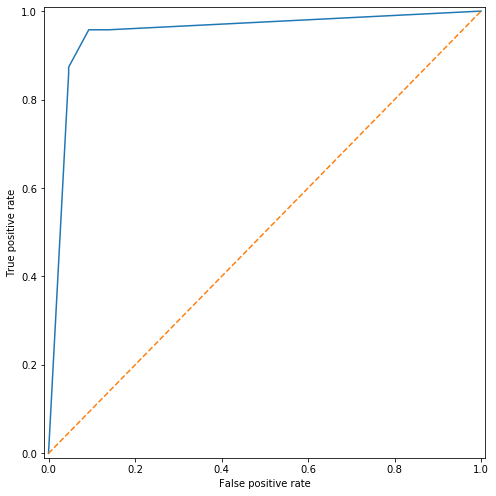

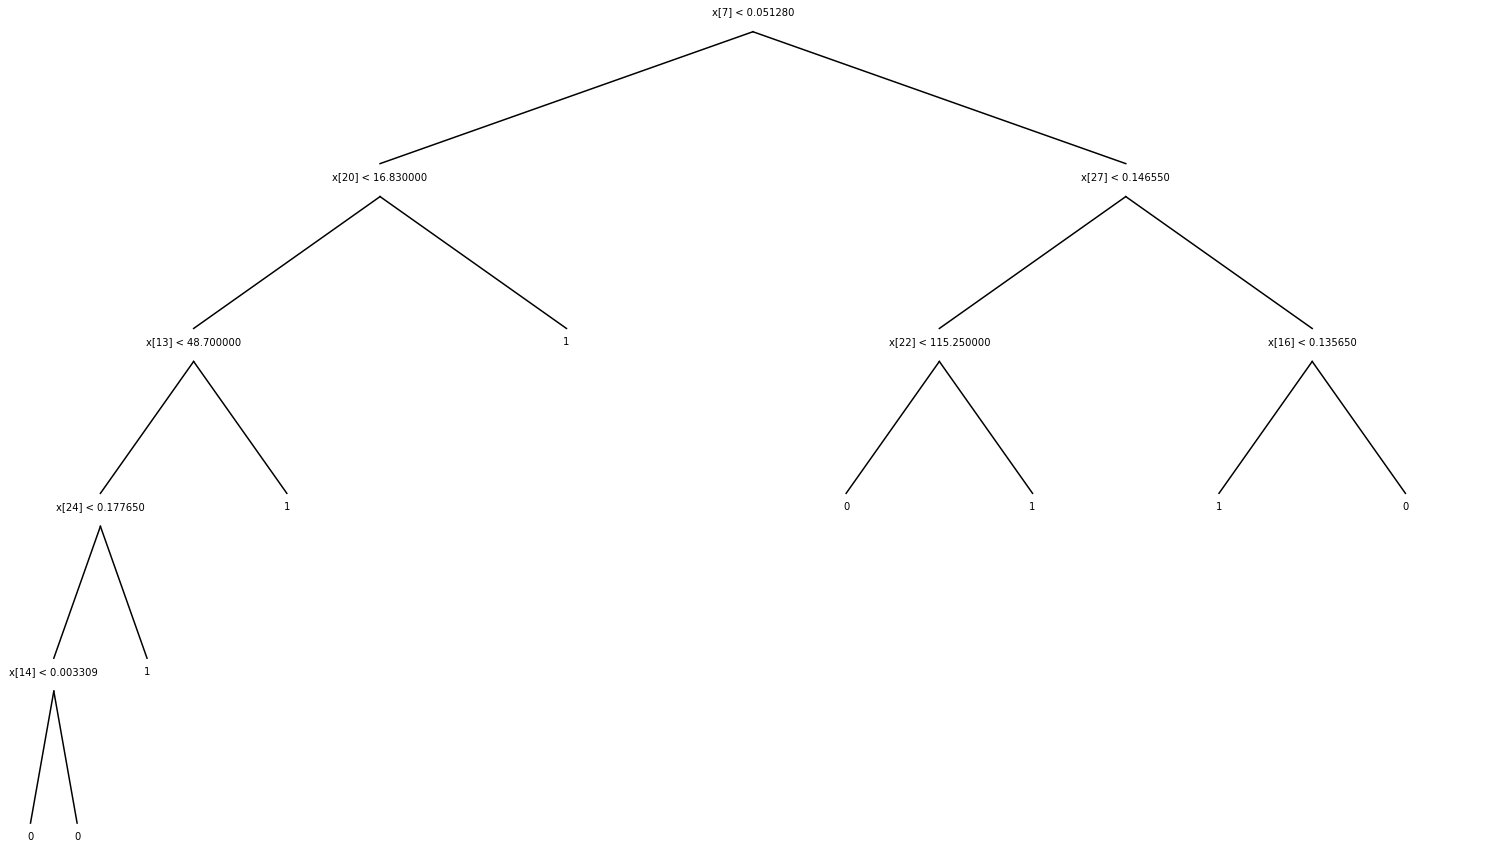

In [183]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
tree = DecisionTreeClassifier(max_depth=5, min_samples_leaf=30)
tree.fit(X_train, y_train)
plot_roc_curve(y_test, tree.predict_proba(X_test))
draw_tree(tree)

In [169]:
y_pred = tree.predict(X_test)

In [170]:
knn = KNeighborsClassifier()
knn.fit(X_train, y_train)
knn_pred = knn.predict(X_test)

In [171]:
print('Tree metrics:')
for label, metric in metrics.items():
    print(f'\t{label}: {metric(y_test, y_pred):.2f}')
print('KNN metrics:')
for label, metric in metrics.items():
    print(f'\t{label}: {metric(y_test, knn_pred):.2f}')    

Tree metrics:
	accuracy: 0.94
	recall: 0.91
	precision: 0.93
KNN metrics:
	accuracy: 0.96
	recall: 0.88
	precision: 1.00


Я не делал скейлинг данных, потому что тут не используются расстояния, точки деления в узлах выбираются между имеющимися точками и не деление не будет зависеть от масштаба и сдвига. Возможно, поэтому дерево дало лучше предсказания по сравнению с KNN (для него нужно было скейлить).

Для этой реализации все фичи должны быть количественными (дискретными или непрерывными).